In [2]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
import pandas as pd
from src.utils import read_jsonl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
import torch

c:\Users\pierr\.conda\envs\irony\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def get_golds_preds(split):
    golds = [item['gold'] for item in split]
    preds = [item['pred'] for item in split]
    return golds, preds

def evaluate_split(split):
    golds, preds = get_golds_preds(split)
    outputs = classification_report(golds, preds, output_dict=True)
    outputs['mcc'] = matthews_corrcoef(golds, preds)
    return outputs

def group_metric(metrics, k, kk=None):
    if kk==None:
        values = [m[k] for m in metrics]
    else:
        values = [m[k][kk] for m in metrics]
    return np.round(np.min(values), 3), f'{np.round(np.mean(values), 3)}({np.round(np.std(values), 3)})', np.round(np.max(values), 3), 

def compute_metric_stats(metrics):
    for k, v in metrics[0].items():
        if isinstance(v, dict):
            for kk, vv in v.items():
                print(k, kk, group_metric(metrics, k, kk))
        else:
            print(k, group_metric(metrics, k))

### cardiff_tweeteval_mcc

In [12]:
df = pd.read_csv('data/sem-eval/test.txt', sep='\t')

for label in sorted(df['Label'].unique()):
    print("#####" + str(label) + "#####")
    metrics = []
    for path in Path('results/cardiff_tweeteval_mcc').glob('*_predictions_*.jsonl'):
        data = read_jsonl(path)
        data = list(filter(lambda x: x['id_original'].startswith('test'), data))
        df['pred'] = [item['pred'] for item in data]
        df['gold'] = [item['gold'] for item in data]
        metrics.append(evaluate_split(df[df['Label'] == label].to_dict(orient='records')))
    compute_metric_stats(metrics)

#####0#####
473
473
473
473
473
0 precision (0.849, '0.871(0.014)', 0.886)
0 recall (0.678, '0.723(0.041)', 0.788)
0 f1-score (0.764, '0.789(0.019)', 0.817)
0 support (292.0, '292.0(0.0)', 292.0)
1 precision (0.619, '0.651(0.027)', 0.693)
1 recall (0.773, '0.825(0.031)', 0.851)
1 f1-score (0.715, '0.727(0.008)', 0.739)
1 support (181.0, '181.0(0.0)', 181.0)
accuracy (0.742, '0.762(0.015)', 0.782)
macro avg precision (0.748, '0.761(0.009)', 0.771)
macro avg recall (0.762, '0.774(0.008)', 0.785)
macro avg f1-score (0.74, '0.758(0.013)', 0.774)
macro avg support (473.0, '473.0(0.0)', 473.0)
weighted avg precision (0.778, '0.787(0.006)', 0.797)
weighted avg recall (0.742, '0.762(0.015)', 0.782)
weighted avg f1-score (0.746, '0.765(0.014)', 0.784)
weighted avg support (473.0, '473.0(0.0)', 473.0)
mcc (0.509, '0.535(0.017)', 0.554)
#####1#####
164
164
164
164
164
0 precision (0.835, '0.867(0.028)', 0.907)
0 recall (0.695, '0.731(0.037)', 0.8)
0 f1-score (0.775, '0.792(0.015)', 0.817)
0 suppo

0 precision (0.837, '0.861(0.016)', 0.88)
0 recall (0.66, '0.705(0.045)', 0.78)
0 f1-score (0.748, '0.774(0.021)', 0.807)
0 support (473.0, '473.0(0.0)', 473.0)
1 precision (0.619, '0.65(0.027)', 0.697)
1 recall (0.768, '0.825(0.034)', 0.862)
1 f1-score (0.714, '0.726(0.007)', 0.733)
1 support (311.0, '311.0(0.0)', 311.0)
accuracy (0.732, '0.753(0.015)', 0.776)
macro avg precision (0.742, '0.755(0.008)', 0.767)
macro avg recall (0.751, '0.765(0.008)', 0.774)
macro avg f1-score (0.731, '0.75(0.013)', 0.769)
macro avg support (784.0, '784.0(0.0)', 784.0)
weighted avg precision (0.767, '0.777(0.006)', 0.784)
weighted avg recall (0.732, '0.753(0.015)', 0.776)
weighted avg f1-score (0.735, '0.755(0.014)', 0.777)
weighted avg support (784.0, '784.0(0.0)', 784.0)
mcc (0.493, '0.52(0.016)', 0.541)


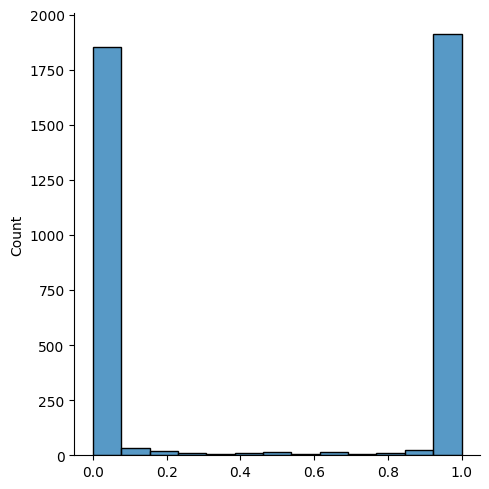

In [6]:
metrics = []
scores = []
for path in Path('results/cardiff_tweeteval_mcc').glob('*_predictions_*.jsonl'):
    data = read_jsonl(path)
    metrics.append(evaluate_split(data))
    scores += [item['score'][1] for item in data]
compute_metric_stats(metrics)
sns.displot(scores)

In [9]:
logs = []
for path in Path('results/cardiff_tweeteval_mcc').glob('*_logs_*.csv'):
    logs.append(pd.read_csv(path))
pd.Series([len(log) / 2 for log in logs]).describe()

count     5.000000
mean     19.200000
std       4.658326
min      13.000000
25%      16.000000
50%      20.000000
75%      23.000000
max      24.000000
dtype: float64

<Axes: xlabel='epoch', ylabel='loss'>

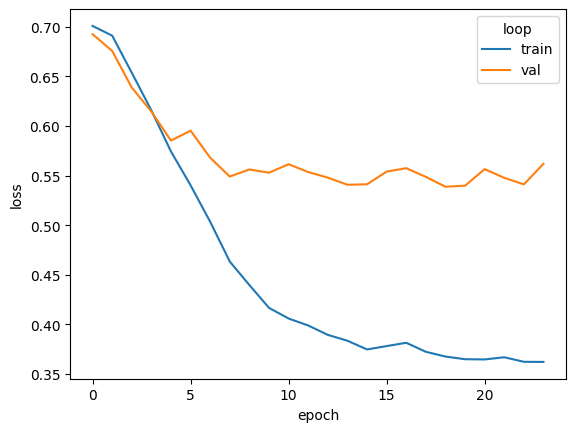

In [27]:
logs = []
for path in Path('results/cardiff_tweeteval_bce').glob('*_logs_*.csv'):
    logs.append(pd.read_csv(path))

df = logs[1]
rows = []
for epoch in df['epoch'].unique():
    x = df[df['epoch'] == epoch].tail(2).reset_index()
    rows.append((epoch, x['train_loss'].values[1], 'train'))
    rows.append((epoch, x['val_loss'].values[0], 'val'))
df.head()
sns.lineplot(pd.DataFrame(rows, columns=['epoch', 'loss', 'loop']), x='epoch', y='loss', hue="loop")

### cardiff_tweeteval_bce

In [11]:
df = pd.read_csv('data/sem-eval/test.txt', sep='\t')

for label in df['Label'].unique():
    print("#####" + str(label) + "#####")
    metrics = []
    for path in Path('results/cardiff_tweeteval_bce').glob('*_predictions_*.jsonl'):
        data = read_jsonl(path)
        df['pred'] = [item['pred'] for item in data]
        df['gold'] = [item['gold'] for item in data]
        metrics.append(evaluate_split(df[df['Label'] == label].to_dict(orient='records')))
    compute_metric_stats(metrics)

#####0#####
0 precision (0.831, 0.862, 0.907, 0.027)
0 recall (0.668, 0.754, 0.842, 0.066)
0 f1-score (0.769, 0.802, 0.837, 0.027)
0 support (292.0, 292.0, 292.0, 0.0)
1 precision (0.624, 0.675, 0.74, 0.046)
1 recall (0.724, 0.8, 0.89, 0.06)
1 f1-score (0.719, 0.728, 0.733, 0.005)
1 support (181.0, 181.0, 181.0, 0.0)
accuracy (0.753, 0.772, 0.797, 0.019)
macro avg precision (0.752, 0.768, 0.786, 0.012)
macro avg recall (0.767, 0.777, 0.783, 0.006)
macro avg f1-score (0.749, 0.765, 0.784, 0.015)
macro avg support (473.0, 473.0, 473.0, 0.0)
weighted avg precision (0.78, 0.79, 0.799, 0.007)
weighted avg recall (0.753, 0.772, 0.797, 0.019)
weighted avg f1-score (0.756, 0.774, 0.797, 0.017)
weighted avg support (473.0, 473.0, 473.0, 0.0)
mcc (0.519, 0.545, 0.569, 0.018)
#####2#####
0 precision (0.709, 0.755, 0.811, 0.034)
0 recall (0.612, 0.722, 0.796, 0.076)
0 f1-score (0.698, 0.734, 0.765, 0.028)
0 support (49.0, 49.0, 49.0, 0.0)
1 precision (0.604, 0.646, 0.688, 0.035)
1 recall (0.556, 0

In [13]:
df = pd.read_csv('data/sem-eval/test.txt', sep='\t')

for label in sorted(df['Label'].unique()):
    print("#####" + str(label) + "#####")
    metrics = []
    for path in Path('results/cardiff_tweeteval_bce').glob('*_predictions_*.jsonl'):
        data = read_jsonl(path)
        data = list(filter(lambda x: x['id_original'].startswith('test'), data))
        df['pred'] = [item['pred'] for item in data]
        df['gold'] = [item['gold'] for item in data]
        metrics.append(evaluate_split(df[df['Label'] == label].to_dict(orient='records')))
    compute_metric_stats(metrics)

#####0#####
0 precision (0.831, '0.862(0.027)', 0.907)
0 recall (0.668, '0.754(0.066)', 0.842)
0 f1-score (0.769, '0.802(0.027)', 0.837)
0 support (292.0, '292.0(0.0)', 292.0)
1 precision (0.624, '0.675(0.046)', 0.74)
1 recall (0.724, '0.8(0.06)', 0.89)
1 f1-score (0.719, '0.728(0.005)', 0.733)
1 support (181.0, '181.0(0.0)', 181.0)
accuracy (0.753, '0.772(0.019)', 0.797)
macro avg precision (0.752, '0.768(0.012)', 0.786)
macro avg recall (0.767, '0.777(0.006)', 0.783)
macro avg f1-score (0.749, '0.765(0.015)', 0.784)
macro avg support (473.0, '473.0(0.0)', 473.0)
weighted avg precision (0.78, '0.79(0.007)', 0.799)
weighted avg recall (0.753, '0.772(0.019)', 0.797)
weighted avg f1-score (0.756, '0.774(0.017)', 0.797)
weighted avg support (473.0, '473.0(0.0)', 473.0)
mcc (0.519, '0.545(0.018)', 0.569)
#####1#####
0 precision (0.811, '0.833(0.013)', 0.849)
0 recall (0.653, '0.754(0.059)', 0.811)
0 f1-score (0.734, '0.79(0.032)', 0.824)
0 support (95.0, '95.0(0.0)', 95.0)
1 precision (0.6

In [82]:
df = pd.read_csv('data/sem-eval/test.txt', sep='\t')

for label in df['Label'].unique():
    print("#####" + str(label) + "#####")
    metrics = []
    for path in Path('results/cardiff_tweeteval_bce').glob('*_predictions_*.jsonl'):
        data = read_jsonl(path)
        df['pred'] = [item['pred'] for item in data]
        df['gold'] = [item['gold'] for item in data]
        metrics.append(evaluate_split(df[df['Label'] == label].to_dict(orient='records')))
    compute_metric_stats(metrics)

#####0#####
0 precision (0.831, 0.862, 0.907, 0.027)
0 recall (0.668, 0.754, 0.842, 0.066)
0 f1-score (0.769, 0.802, 0.837, 0.027)
0 support (292.0, 292.0, 292.0, 0.0)
1 precision (0.624, 0.675, 0.74, 0.046)
1 recall (0.724, 0.8, 0.89, 0.06)
1 f1-score (0.719, 0.728, 0.733, 0.005)
1 support (181.0, 181.0, 181.0, 0.0)
accuracy (0.753, 0.772, 0.797, 0.019)
macro avg precision (0.752, 0.768, 0.786, 0.012)
macro avg recall (0.767, 0.777, 0.783, 0.006)
macro avg f1-score (0.749, 0.765, 0.784, 0.015)
macro avg support (473.0, 473.0, 473.0, 0.0)
weighted avg precision (0.78, 0.79, 0.799, 0.007)
weighted avg recall (0.753, 0.772, 0.797, 0.019)
weighted avg f1-score (0.756, 0.774, 0.797, 0.017)
weighted avg support (473.0, 473.0, 473.0, 0.0)
mcc (0.519, 0.545, 0.569, 0.018)
#####2#####
0 precision (0.709, 0.755, 0.811, 0.034)
0 recall (0.612, 0.722, 0.796, 0.076)
0 f1-score (0.698, 0.734, 0.765, 0.028)
0 support (49.0, 49.0, 49.0, 0.0)
1 precision (0.604, 0.646, 0.688, 0.035)
1 recall (0.556, 0

0 precision (0.812, '0.843(0.024)', 0.882)
0 recall (0.647, '0.741(0.067)', 0.825)
0 f1-score (0.746, '0.786(0.028)', 0.818)
0 support (473.0, '473.0(0.0)', 473.0)
1 precision (0.618, '0.672(0.043)', 0.727)
1 recall (0.711, '0.786(0.056)', 0.868)
1 f1-score (0.714, '0.721(0.005)', 0.727)
1 support (311.0, '311.0(0.0)', 311.0)
accuracy (0.735, '0.759(0.019)', 0.779)
macro avg precision (0.743, '0.758(0.011)', 0.77)
macro avg recall (0.753, '0.764(0.007)', 0.773)
macro avg f1-score (0.734, '0.754(0.015)', 0.771)
macro avg support (784.0, '784.0(0.0)', 784.0)
weighted avg precision (0.765, '0.775(0.006)', 0.781)
weighted avg recall (0.735, '0.759(0.019)', 0.779)
weighted avg f1-score (0.737, '0.76(0.018)', 0.78)
weighted avg support (784.0, '784.0(0.0)', 784.0)
mcc (0.496, '0.521(0.017)', 0.542)


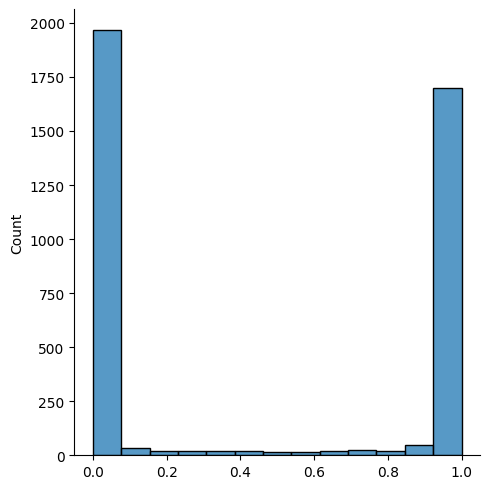

In [7]:
metrics = []
scores = []
for path in Path('results/cardiff_tweeteval_bce').glob('*_predictions_*.jsonl'):
    data = read_jsonl(path)
    metrics.append(evaluate_split(data))
    scores += [item['score'][1] for item in data]
compute_metric_stats(metrics)
sns.displot(scores)

In [60]:
logs = []
for path in Path('results/cardiff_tweeteval_bce').glob('*_logs_*.csv'):
    logs.append(pd.read_csv(path))
pd.Series([len(log) / 2 for log in logs]).describe()

count     5.000000
mean     20.400000
std       3.361547
min      16.000000
25%      18.000000
50%      21.000000
75%      23.000000
max      24.000000
dtype: float64

## cardiff_epic_mcc

In [16]:
from src.utils import load_config
from datasets import Dataset, load_dataset
from src.model import cls_load_epic

config = load_config()

epic = pd.DataFrame(load_dataset(config['DATASET_NAME'])['train'])
epic.head()

,user,label,timestamp,source,subreddit,id_original,text,parent_id_original,parent_text,Language_instance,Language_variety,Age,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language_annotator,Student status,Employment status
0,5dcff5909595a10f6241c0f6,iro,2022-11-05 11:11:23,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,24,Male,White,United Kingdom,United Kingdom,United Kingdom,English,No,Full-Time
1,55057a56fdf99b5b566a70bb,not,2022-11-05 12:10:00,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,29,Female,White,United Kingdom,United Kingdom,United Kingdom,English,No,DATA_EXPIRED
2,5721b3054d5b26001301f651,iro,2022-11-26 13:07:54,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,33,Male,Asian,Australia,Australia,India,English,No,Full-Time
3,60e016cd61cd6e8d3d185ff3,not,2022-11-25 18:47:48,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,41,Female,White,Ireland,Ireland,Ireland,English,No,Part-Time
4,59fc8aba087f2e0001ead671,not,2022-11-25 18:44:10,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,42,Female,White,Ireland,Ireland,Ireland,English,No,Full-Time


0 precision (0.83, '0.849(0.011)', 0.861)
0 recall (0.834, '0.873(0.024)', 0.905)
0 f1-score (0.847, '0.86(0.008)', 0.872)
0 support (409.0, '412.6(2.059)', 415.0)
1 precision (0.511, '0.55(0.027)', 0.586)
1 recall (0.411, '0.498(0.05)', 0.562)
1 f1-score (0.48, '0.52(0.023)', 0.546)
1 support (127.0, '127.8(0.748)', 129.0)
accuracy (0.77, '0.784(0.01)', 0.8)
macro avg precision (0.686, '0.7(0.012)', 0.721)
macro avg recall (0.658, '0.685(0.015)', 0.7)
macro avg f1-score (0.673, '0.69(0.012)', 0.709)
macro avg support (538.0, '540.4(1.625)', 543.0)
weighted avg precision (0.769, '0.778(0.008)', 0.792)
weighted avg recall (0.77, '0.784(0.01)', 0.8)
weighted avg f1-score (0.773, '0.78(0.008)', 0.795)
weighted avg support (538.0, '540.4(1.625)', 543.0)
mcc (0.358, '0.384(0.021)', 0.42)


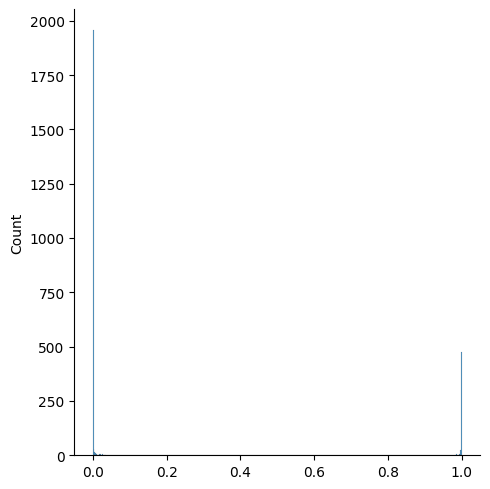

In [8]:
metrics = []
scores = []
for path in Path('results/cardiff_epic_mcc').glob('*_predictions_*.jsonl'):
    data = read_jsonl(path)
    metrics.append(evaluate_split(data))
    scores += [item['score'][1] for item in data]
compute_metric_stats(metrics)
sns.displot(scores)

In [3]:
logs = []
for path in Path('results/cardiff_epic_mcc').glob('*_logs_*.csv'):
    logs.append(pd.read_csv(path))
pd.Series([len(log) / 2 for log in logs]).describe()

count     5.000000
mean     19.200000
std       3.898718
min      15.000000
25%      15.000000
50%      21.000000
75%      22.000000
max      23.000000
dtype: float64

In [5]:
logs = []
for path in Path('results/cardiff_epic_bce').glob('*_logs_*.csv'):
    logs.append(pd.read_csv(path))
pd.Series([len(log) / 2 for log in logs]).describe()

count     5.000000
mean     14.600000
std       5.272571
min       6.000000
25%      14.000000
50%      16.000000
75%      17.000000
max      20.000000
dtype: float64

In [17]:
agreements = [] 
for id in epic['id_original'].unique():
    labels = epic[epic['id_original'] == id]['label']
    agreements.append((id, max((labels == 'iro').sum(), (labels == 'not').sum()) / len(labels)))
agreements = pd.DataFrame(agreements, columns=['id', 'agreement'])
agreements.describe()

,agreement
count,3000.000000
mean,0.793947
std,0.169727
min,0.500000
25%,0.600000
50%,0.800000
75%,1.000000
max,1.000000


In [20]:
for r in [.5, .6, .7, .8, .9, 1]:
    ids = agreements[agreements['agreement'] >= r]['id'].tolist()
    metrics = []
    for path in Path('results/cardiff_epic_mcc').glob('*_predictions_*.jsonl'):
        data = list(filter(lambda x: x['id_original'] in ids, read_jsonl(path)))
        golds, preds = get_golds_preds(data)
        metrics.append(matthews_corrcoef(golds, preds))
    metrics = pd.Series(metrics).describe()
    print(r, len(ids), f"{round(metrics['mean'], 3)}({round(metrics['std'], 3)})")

0.5 3000 0.384(0.023)
0.6 2750 0.39(0.022)
0.7 2038 0.479(0.034)
0.8 1673 0.526(0.026)
0.9 990 0.567(0.055)
1 990 0.567(0.055)


In [22]:
for r in [.5, .6, .7, .8, .9, 1]:
    ids = agreements[agreements['agreement'] >= r]['id'].tolist()
    metrics = []
    for path in Path('results/cardiff_epic_bce').glob('*_predictions_*.jsonl'):
        data = list(filter(lambda x: x['id_original'] in ids, read_jsonl(path)))
        golds, preds = get_golds_preds(data)
        metrics.append(matthews_corrcoef(golds, preds))
    metrics = pd.Series(metrics).describe()
    print(r, len(ids), f"{round(metrics['mean'], 3)}({round(metrics['std'], 3)})")

0.5 3000 0.388(0.077)
0.6 2750 0.391(0.075)
0.7 2038 0.45(0.102)
0.8 1673 0.506(0.104)
0.9 990 0.48(0.147)
1 990 0.48(0.147)


0 precision (0.891, '0.913(0.019)', 0.935)
0 recall (0.909, '0.964(0.04)', 1.0)
0 f1-score (0.922, '0.937(0.011)', 0.952)
0 support (160.0, '174.4(9.308)', 188.0)
1 precision (0.0, '0.219(0.197)', 0.5)
1 recall (0.0, '0.165(0.17)', 0.45)
1 f1-score (0.0, '0.168(0.153)', 0.4)
1 support (16.0, '19.4(2.939)', 23.0)
accuracy (0.862, '0.884(0.018)', 0.909)
macro avg precision (0.445, '0.566(0.106)', 0.709)
macro avg recall (0.5, '0.564(0.066)', 0.679)
macro avg f1-score (0.471, '0.553(0.073)', 0.661)
macro avg support (176.0, '193.8(12.057)', 211.0)
weighted avg precision (0.793, '0.843(0.04)', 0.881)
weighted avg recall (0.862, '0.884(0.018)', 0.909)
weighted avg f1-score (0.839, '0.86(0.017)', 0.883)
weighted avg support (176.0, '193.8(12.057)', 211.0)
mcc (0.0, '0.142(0.127)', 0.325)


c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\iron

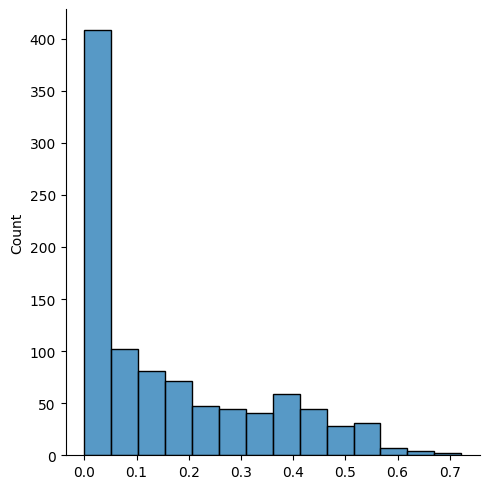

In [8]:
metrics = []
scores = []
for path in Path('results/cardiff_epic_mcc_high').glob('*_predictions_*.jsonl'):
    data = read_jsonl(path)
    metrics.append(evaluate_split(data))
    scores += [item['score'][1] for item in data]
compute_metric_stats(metrics)
sns.displot(scores)

## cardiff_epic_bce

In [14]:
for r in [.5, .6, .7, .8, .9, 1]:
    ids = agreements[agreements['agreement'] >= r]['id'].tolist()
    metrics = []
    for path in Path('results/cardiff_epic_bce').glob('*_predictions_*.jsonl'):
        data = list(filter(lambda x: x['id_original'] in ids, read_jsonl(path)))
        golds, preds = get_golds_preds(data)
        metrics.append(matthews_corrcoef(golds, preds))
    print(r, len(ids), len(set(ids)))
    
    print(pd.Series(metrics).describe()['mean'])
    # for item in data:
    #     if item['gold'] == 1:
    #         labels = epic[epic['id_original'] == item['id_original']]['label']
    #         metrics.append((
    #             int(item['pred'] == item['gold']),
    #             max((labels == 'iro').sum(), (labels == 'not').sum()) / len(labels),
    #         ))

NameError: name 'agreements' is not defined

0 precision (0.842, '0.87(0.021)', 0.895)
0 recall (0.742, '0.804(0.044)', 0.854)
0 f1-score (0.802, '0.835(0.026)', 0.866)
0 support (409.0, '412.6(2.059)', 415.0)
1 precision (0.427, '0.495(0.053)', 0.568)
1 recall (0.488, '0.61(0.077)', 0.695)
1 f1-score (0.484, '0.544(0.051)', 0.606)
1 support (127.0, '127.8(0.748)', 129.0)
accuracy (0.714, '0.758(0.033)', 0.798)
macro avg precision (0.637, '0.682(0.034)', 0.723)
macro avg recall (0.663, '0.707(0.038)', 0.754)
macro avg f1-score (0.644, '0.689(0.035)', 0.732)
macro avg support (538.0, '540.4(1.625)', 543.0)
weighted avg precision (0.747, '0.781(0.026)', 0.812)
weighted avg recall (0.714, '0.758(0.033)', 0.798)
weighted avg f1-score (0.726, '0.766(0.029)', 0.801)
weighted avg support (538.0, '540.4(1.625)', 543.0)
mcc (0.299, '0.388(0.069)', 0.472)


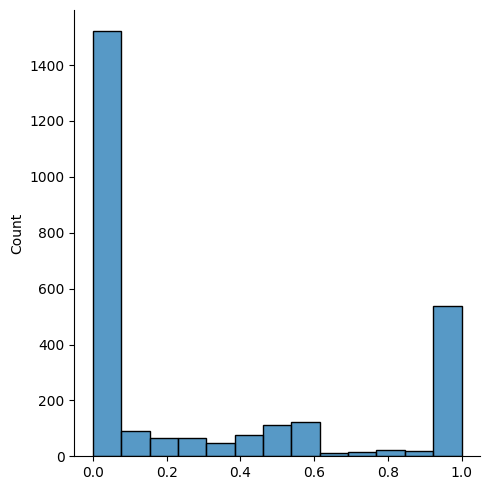

In [9]:
metrics = []
scores = []
for path in Path('results/cardiff_epic_bce').glob('*_predictions_*.jsonl'):
    data = read_jsonl(path)
    metrics.append(evaluate_split(data))
    scores += [item['score'][1] for item in data]
compute_metric_stats(metrics)
sns.displot(scores)